In [1]:
from pympi.Elan import Eaf
from src.settings import ORKPJM_ANN_DIR, TASK_NUM_NAME_MAP
from loguru import logger
from collections import defaultdict
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

## Tiers:

### Data structure
_TimeStamp: int
> - in `TIME_UNITS`, miliseconds

_Content: str
> - `glosa*`: utf-8,
> - `HamNoSys`: unicode (font HamNoSys)
> - `tlumaczenie_publikacja`: utf-8

Tier results:
> ```python
> List[Tuple[ts1: _TimeStamp, ts2: _TimeStamp, content: _Content]]
> ```

In [2]:
tier_records = defaultdict(list)
for task_dir_path in tqdm(list(ORKPJM_ANN_DIR.iterdir()), desc="Tasks"):
    if not task_dir_path.is_dir():
        continue
    task_num = task_dir_path.name
    for eaf_doc_filepath in task_dir_path.glob("*.eaf"):
        eac_doc_rel_filepath = eaf_doc_filepath.as_posix().replace(ORKPJM_ANN_DIR.as_posix(), "")
        eaf_doc = Eaf(eaf_doc_filepath)
        if len(eaf_doc.media_descriptors) > 1:
            logger.warning(f"More than one media descriptors! Getting the first one...\n{eaf_doc.media_descriptors=}")
        media_descriptor = eaf_doc.media_descriptors[0]
        vid_fname = media_descriptor["MEDIA_URL"]
        time_units = eaf_doc.header["TIME_UNITS"]
        for tier_name in eaf_doc.get_tier_names():
            tier_data = eaf_doc.get_annotation_data_for_tier(tier_name)
            for tier_record in tier_data:
                record = {
                    "TaskNum": task_num,
                    "DocFilePath": eac_doc_rel_filepath,
                    "VideoFileName": vid_fname,
                    "TimeUnit": time_units,
                    "TierId": tier_name,
                    "TimeStampStart": tier_record[0],
                    "TimeStampEnd": tier_record[1],
                    "Content": tier_record[2],
                }
                tier_records[tier_name].append(record)

Tasks:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
glosa_df = pd.DataFrame.from_records(tier_records["glosa"])
glosa_df

,TaskNum,DocFilePath,VideoFileName,TimeUnit,TierId,TimeStampStart,TimeStampEnd,Content
0,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa,29960,31200,%
1,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa,38560,39040,%
2,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa,39040,39440,MYŚLEĆ 2.1 P:Z;L:Z (NA PRZEMIAN)
3,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa,39440,39640,JAK 1.2 P:I;L:Ø
4,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa,39640,39920,POMYSŁ 1.3 P:AZ;L:Ø
...,...,...,...,...,...,...,...,...
160671,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,glosa,353480,354480,NIEDŹWIEDŹ/MIŚ 1.2 P:B;L:Ø
160672,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,glosa,354680,356440,PRZESTRASZYĆ 1.1 P:5A;L:5A (JAK ZŁAPAĆ)
160673,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,glosa,359240,360120,BIUSTONOSZ 1.2. P:5;L:5 (STANIK/STRÓJ KĄPIELOWY)
160674,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,glosa,360120,360960,DZIECKO 2.2 P:I1;LØ


In [28]:
def print_tier_eda(tier_df: pd.DataFrame, tier_id: str):
    df = tier_df.copy()
    sns.countplot(data=df, x="TaskNum")
    plt.title(f"Task distribution (tier: `{tier_id}`)")
    plt.ylabel("Count")
    plt.show()
    
    assert df.TimeUnit.unique().shape[0] == 1
    print(f"{df.TimeUnit.unique()=}")
    print(
        f"{df.VideoFileName.nunique()=}\n"
        f"{df.DocFilePath.nunique()=}"
    )

    df["SliceDuration"] = df.TimeStampEnd - df.TimeStampStart
    print(f"\n{df.SliceDuration.describe()=}")
    

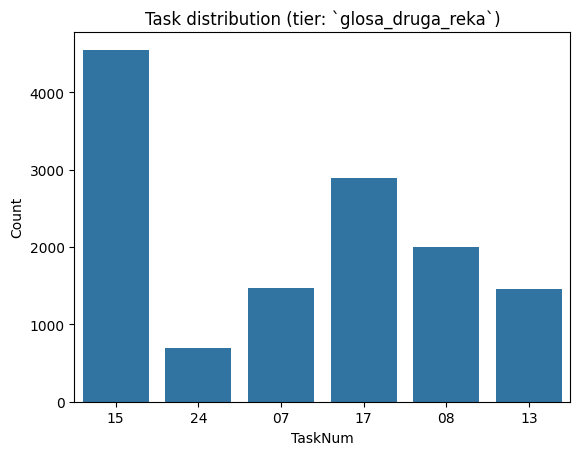

df.TimeUnit.unique()=array(['milliseconds'], dtype=object)
df.VideoFileName.nunique()=269
df.DocFilePath.nunique()=654

df.SliceDuration.describe()=count    13070.000000
mean      1104.636572
std        928.865381
min         40.000000
25%        520.000000
50%        840.000000
75%       1360.000000
max      16160.000000
Name: SliceDuration, dtype: float64



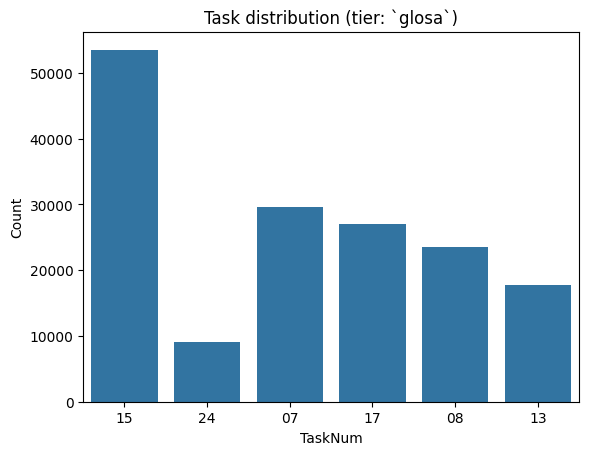

df.TimeUnit.unique()=array(['milliseconds'], dtype=object)
df.VideoFileName.nunique()=281
df.DocFilePath.nunique()=739

df.SliceDuration.describe()=count    160676.000000
mean        638.261346
std         583.700889
min          40.000000
25%         360.000000
50%         520.000000
75%         760.000000
max       70400.000000
Name: SliceDuration, dtype: float64



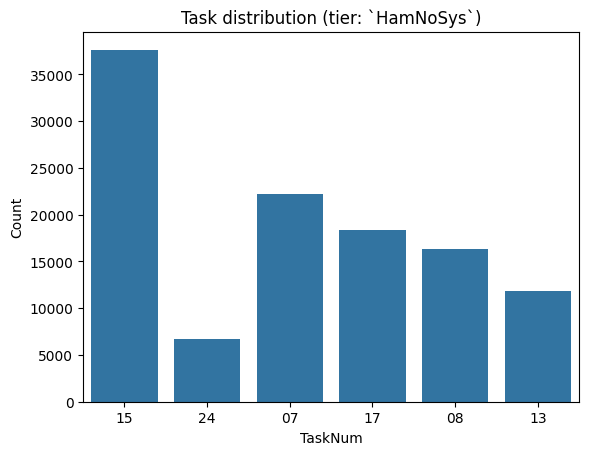

df.TimeUnit.unique()=array(['milliseconds'], dtype=object)
df.VideoFileName.nunique()=281
df.DocFilePath.nunique()=739

df.SliceDuration.describe()=count    113210.000000
mean        605.287165
std         458.788974
min          40.000000
25%         360.000000
50%         480.000000
75%         720.000000
max       19960.000000
Name: SliceDuration, dtype: float64



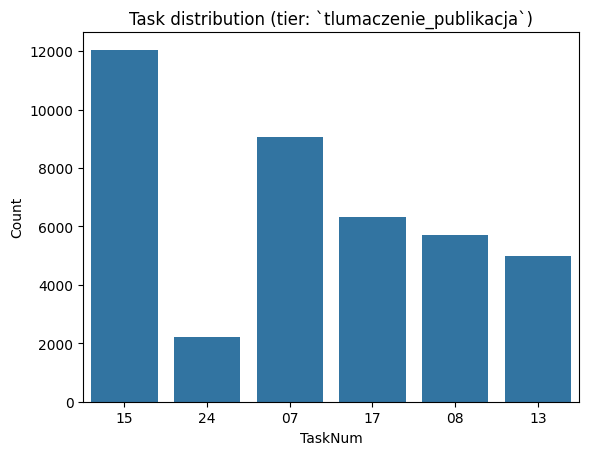

df.TimeUnit.unique()=array(['milliseconds'], dtype=object)
df.VideoFileName.nunique()=281
df.DocFilePath.nunique()=739

df.SliceDuration.describe()=count    40355.000000
mean      2415.649114
std       2109.135549
min         40.000000
25%       1000.000000
50%       1800.000000
75%       3120.000000
max      55720.000000
Name: SliceDuration, dtype: float64



In [29]:
for tier_id in tier_records.keys():
    print_tier_eda(
        tier_df=pd.DataFrame.from_records(tier_records[tier_id]),
        tier_id=tier_id
    )
    print()
    print("="*80)

In [30]:
ann_full_df = pd.concat(
    objs=[
        pd.DataFrame.from_records(tier_records[tier_id])
        for tier_id in tier_records.keys()
    ]
)
ann_full_df

,TaskNum,DocFilePath,VideoFileName,TimeUnit,TierId,TimeStampStart,TimeStampEnd,Content
0,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa_druga_reka,49680,51840,IŚĆ 1.3 P:1;L:1 (ROZDZIELNIE)
1,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa_druga_reka,67920,68400,WSKAZ: Z WSZYSTKIE KIERUNKI
2,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa_druga_reka,195160,196160,NUM: TRZECI-PUNKT 1.3 P:Z;L:3\t
3,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa_druga_reka,270600,271200,WSKAZ: Z WSZYSTKIE KIERUNKI
4,15,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,milliseconds,glosa_druga_reka,361560,362240,ZŁAPAĆ 1.2 P:5A;L:Ø
...,...,...,...,...,...,...,...,...
40350,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,tlumaczenie_publikacja,248960,250320,[uderzanie w coś]
40351,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,tlumaczenie_publikacja,279560,291400,Kot zobaczył w akwarium rybkę. Podszedł i dał ...
40352,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,tlumaczenie_publikacja,291400,347120,"Zjadłam, zjadłam."
40353,13,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,milliseconds,tlumaczenie_publikacja,347120,356440,"Zając biegnie, zobaczył wiszące pranie. Wskocz..."


In [31]:
ann_full_df.TimeUnit.unique()

array(['milliseconds'], dtype=object)

In [32]:
ann_full_df.TierId.unique()

array(['glosa_druga_reka', 'glosa', 'HamNoSys', 'tlumaczenie_publikacja'],
      dtype=object)